Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# This notebook deploys a registered model as a simple web service

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
import pickle
import azureml.core
from azureml.core import Workspace
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Experiment

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [3]:
project_folder=os.getcwd()
data_folder='trainDataset'
script_folder='scripts' 
os.makedirs(script_folder, exist_ok=True)

# Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`. Here we also create the object pointing to the default datastore 'ds'

In [5]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
ws = Workspace(subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b' ,resource_group='20191107_DNNhyperdrive', workspace_name = 'WS1' )

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

AzureBlob ws11078562529 azureml-blobstore-15002b44-9629-4d8c-a66d-71dde33561ab
WS1	westeurope	20191107_DNNhyperdrive	westeurope


# Deployment

### Display registered models with versions

In [6]:
models = ws.models
for name, m in models.items():
    print("Name:", name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: onnxmodel 	Version: 1 	Description: None {}
Name: LHdemo 	Version: 1 	Description: None {}
Name: AutoML67c20ca3694 	Version: 1 	Description: None {}
Name: tf-dnn-mnist 	Version: 1 	Description: None {}
Name: DNNdemo 	Version: 1 	Description: None {}


In [8]:
from azureml.core.model import Model
import os

model = Model(workspace=ws, name="DNNdemo", version=1)
model.download(target_dir=os.getcwd(),exist_ok=True)
model

Model(workspace=Workspace.create(name='WS1', subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b', resource_group='20191107_DNNhyperdrive'), name=DNNdemo, id=DNNdemo:1, version=1, tags={}, properties={})

### Create scoring script - score.py

In [9]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from keras.models import model_from_json
from azureml.core.model import Model

def init():
    global model    
    model_root = Model.get_model_path('DNNdemo')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
     
        
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

Writing score.py


## Environment

In [14]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy","azureml-defaults"],
                                )
myenv.add_conda_package('tensorflow')
myenv.add_conda_package('keras')
with open("score_env.yml","w") as f:
    f.write(myenv.serialize_to_string())

## Config

In [15]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime="python",
                                   entry_script="score.py",
                                   conda_file="score_env.yml")

In [25]:
from azureml.core.webservice import AciWebservice
from azureml.core.image import ContainerImage


aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'demo': 'simple deployment'}, 
                                               description = 'web service for DNN demo model')

## Deploy

In [21]:
serviceName = 'dnn-demo'

In [27]:
from azureml.core.webservice import  AciWebservice
from azureml.core.model import Model

serviceName2=serviceName+'-aci'

service = Model.deploy( ws, 
                        serviceName2, 
                        [model], 
                        inference_config, 
                        aci_config)

service.wait_for_deployment(show_output = True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-10 18:03:36+02:00 Creating Container Registry if not exists.
2021-05-10 18:03:37+02:00 Registering the environment.
2021-05-10 18:03:38+02:00 Use the existing image.
2021-05-10 18:03:38+02:00 Generating deployment configuration.
2021-05-10 18:03:40+02:00 Submitting deployment to compute..
2021-05-10 18:03:52+02:00 Checking the status of deployment dnn-demo-aci..
2021-05-10 18:05:56+02:00 Checking the status of inference endpoint dnn-demo-aci.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [29]:
print(service.get_logs())

2021-05-10T16:05:53,942297400+00:00 - gunicorn/run 
2021-05-10T16:05:53,941949600+00:00 - rsyslog/run 
2021-05-10T16:05:53,958518800+00:00 - iot-server/run 
2021-05-10T16:05:53,990131700+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_51a8feaf545b6d045a38ed05265ae03e/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_51a8feaf545b6d045a38ed05265ae03e/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_51a8feaf545b6d045a38ed05265ae03e/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_51a8feaf545b6d045a38ed05265ae03e/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_51a8feaf545b6d045a38ed05265ae03e/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
EdgeHubC

# Test the service

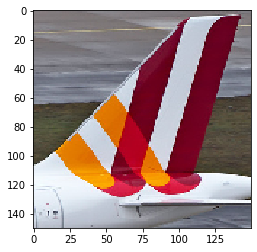

In [30]:
with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
with open(os.path.join('testDataset', "y_test.tsv"),"rb") as f:
     y_test=pickle.load(f)
with open(os.path.join('trainDataset', "encoder"),"rb") as f:
     encoder=pickle.load(f)
        
test_sample_x=x_test[2]
test_sample_y=y_test[2]

test_sample_x

plt.imshow(test_sample_x, cmap=plt.cm.Greys)


In [31]:
import json

testx=np.expand_dims(test_sample_x, axis=0)
test_json=json.dumps({'data':testx.tolist()})


In [33]:

predicted = service.run(input_data = test_json)

predictedLabel= encoder.inverse_transform(predicted)
print('predicted label', predictedLabel)
print('true label', test_sample_y)

predicted label ['4U']
true label 4U
